# Connection between the FoM, Accuracy and AUC/ROC

In the JSNS<sup>2</sup> experiment, discrimination power of the conventional PSD was reported in terms of the Figure of Merit (FoM). The FoM is computed with the formula:

<center>$\text{FoM} = \frac{|\mu_1-\mu_2|}{\sqrt{\sigma_1^2 + \sigma_2^2}}$,</center>

where the $\mu_1, \sigma_1$ and $\mu_2, \sigma_2$ are taken from the gaussian fits.

The figure attached below is one of the example fit results (https://lsa-phys-spitz-docdb.miserver.it.umich.edu/jsns2/0018/001891/001/20210729%20DIN%20%28Collaboration%29.pdf)

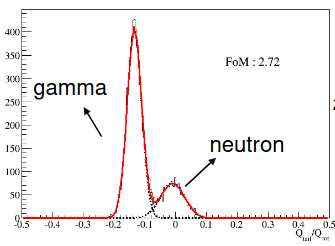

In contrast, the standard metric in the classification problems is accuracy which is defined like:

<center>$\text{Accuracy} = \frac{TP+TN}{Total}$,</center>

where TP and TN are number of True-Positive and True-Negative events, therefore giving the fraction of number of events with correct answer. 

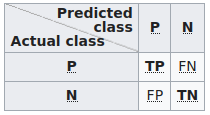

There are other metrics in the Machine Learning. One of the widely used metric to measure the power of the classifiers, the area under the ROC curve. The ROC curve is a curve between the true-positive ratio (TPR) and false-positive ratio (FPR). If we write in formula:

<center>$\text{TPR} = \frac{TP}{TP+FN} = \frac{\int_{x_o}^{\infty} S(x)dx}{\int_{-\infty}^{\infty} S(x)dx}$,  
    $\text{FPR} = \frac{FP}{FP+TN} = \frac{\int_{-\infty}^{x_o} B(x)dx}{\int_{-\infty}^{\infty} B(x)dx}$,</center>
    

In this document, we will show connections between the FoM, accuracy and the ROC.


## Numerical analysis with fixed shape

First exercise with fixed $\mu_1, \mu_2, \sigma_1, \sigma_2$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

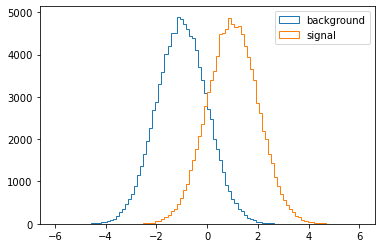

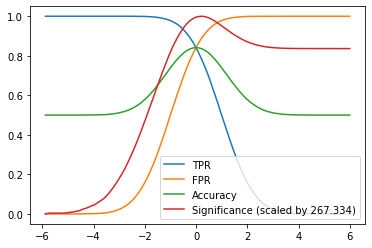

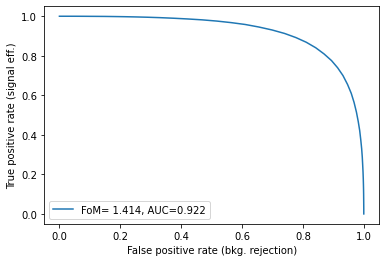

FoM= 1.414, AUC=0.922
Best accuracy=84.1% at threshold>-0.120, sigEff=84.1% bkgEff=15.8%


In [2]:
## cat1 = background, cat2 = signal
mu1, mu2, sigma1, sigma2 = -1, 1, 1, 1
nEvent = 100000
nbins = 100

fom = abs(mu1-mu2)/np.sqrt(sigma1*sigma1+sigma2*sigma2)

data1 = np.random.normal(mu1, sigma1, nEvent)
data2 = np.random.normal(mu2, sigma2, nEvent)

xmin, xmax = min(mu1-5*sigma1, mu2-5*sigma2), max(mu1+5*sigma1, mu2+5*sigma2)
h1, bins, _ = plt.hist(data1, bins=nbins, range=(xmin,xmax), histtype='step', label="background")
h2, _, _ = plt.hist(data2, bins=nbins, range=(xmin,xmax), histtype='step', label="signal")
plt.legend()
plt.show()

y1 = np.cumsum(h1)
y2 = np.cumsum(h2)

tpr = 1-y2/nEvent
fpr = y1/nEvent

acc = (y1+(nEvent-y2))/(len(data1)+len(data2))
signif = np.divide(y1, np.sqrt(y1+y2), out=np.zeros_like(y1), where=np.sqrt(y1+y2)!=0)
maxSignif = max(signif[1:])

plt.plot(bins[1:], tpr, label="TPR")
plt.plot(bins[1:], fpr, label="FPR")
plt.plot(bins[1:], acc, label="Accuracy")
plt.plot(bins[1:], signif/maxSignif, label="Significance (scaled by %.3f)" % maxSignif)
plt.legend()
plt.show()

auc = np.trapz(tpr, fpr)
iMaxAcc = np.argmax(acc)
sigEff = tpr[iMaxAcc]
bkgEff = 1-fpr[iMaxAcc]
 
roc = plt.plot(fpr, tpr, label=("FoM= %.3f, AUC=%.3f" % (fom, auc)))
plt.xlabel("False positive rate (bkg. rejection)")
plt.ylabel("True positive rate (signal eff.)")
plt.legend()
plt.show()

print("FoM= %.3f, AUC=%.3f" % (fom, auc))
print("Best accuracy=%.1f%% at threshold>%.3f, sigEff=%.1f%% bkgEff=%.1f%%" % (100*acc[iMaxAcc], bins[iMaxAcc], 100*sigEff, 100*bkgEff))


## Numerical analysis with different shape parameters
We extend the study with different paramters

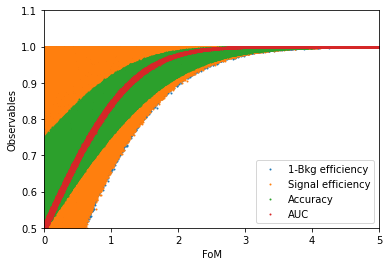

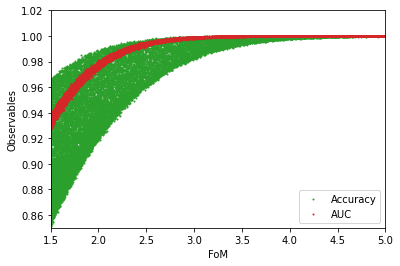

In [60]:
# global parameters
nExp = 100000
nEvent = 10000
nbins = 1000

def getFoM(mu1, mu2, sigma1, sigma2):
    return abs(mu1-mu2)/np.sqrt(sigma1*sigma1+sigma2*sigma2)

def getAcc(y1, y2, n1, n2):
    return (y1+(n2-y2))/(n1+n2)

def getSignif(y1, y2):
    yy = np.sqrt(y1+y2)
    return np.divide(y1, yy, out=np.zeros_like(y1).astype(np.float32), where=(yy!=0.))

foms, aucs, accs = [], [], []
signifs, sigEffs, bkgEffs = [], [], []
#for i in tqdm(range(nExp)):
for i in range(nExp):
    ## cat1 = background, cat2 = signal
    mu1 = np.random.uniform(-10, 10)
    mu2 = np.random.uniform(-10, 10)
    if mu1 > mu2:
        mu1, mu2 = mu2, mu1
    sigma1 = np.random.uniform(0, 10)
    sigma2 = np.random.uniform(0, 10)

    data1 = np.random.normal(mu1, sigma1, nEvent)
    data2 = np.random.normal(mu2, sigma2, nEvent)

    xmin, xmax = min(mu1-5*sigma1, mu2-5*sigma2), max(mu1+5*sigma1, mu2+5*sigma2)
    h1, bins = np.histogram(data1, bins=nbins, range=(xmin,xmax))
    h2, _ = np.histogram(data2, bins=nbins, range=(xmin,xmax))

    y1 = np.cumsum(h1)
    y2 = np.cumsum(h2)

    tpr = 1-y2/nEvent
    fpr = y1/nEvent
    
    acc = getAcc(y1, y2, len(data1), len(data2))
    signif = getSignif(y1, y2)

    maxSignif = max(signif[1:])

    auc = np.trapz(tpr, fpr)
    iMaxAcc = np.argmax(acc)
    
    foms.append(getFoM(mu1, mu2, sigma1, sigma2))
    aucs.append(auc)
    accs.append(acc[iMaxAcc])
    signifs.append(maxSignif)
    sigEffs.append(tpr[iMaxAcc])
    bkgEffs.append(1-fpr[iMaxAcc])
    
sigEffs = np.array(sigEffs)
bkgEffs = np.array(bkgEffs)
 
plt.xlabel("FoM")
plt.ylabel("Observables")
plt.xlim(0.0, 5)
plt.ylim(0.5, 1.1)
plt.scatter(foms, 1-bkgEffs, s=1, label="1-Bkg efficiency")
plt.scatter(foms, sigEffs, s=1, label="Signal efficiency")
plt.scatter(foms, accs, s=1, c='#2ca02c', label="Accuracy")
plt.scatter(foms, aucs, s=1, c='#d62728', label="AUC")
plt.legend()
plt.show()


plt.xlabel("FoM")
plt.ylabel("Observables")
plt.xlim(1.5, 5)
plt.ylim(0.85, 1.02)
plt.scatter(foms, accs, s=1, c='#2ca02c', label="Accuracy")
plt.scatter(foms, aucs, s=1, c='#d62728', label="AUC")
plt.legend()
plt.show()